# Import


# Calculate Functions

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import seaborn as sns
from tqdm import tqdm
import re

## Standard Template
사이즈 비교의 대상이 되는 템플릿


## Load Image and Show Image

In [2]:
def load_image(path, scale = 0.7):
    img = cv2.imread(path)
    img_resized = cv2.resize(img, (0,0), None, scale, scale)
    return img_resized

def show_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.xticks([])
    plt.yticks([]) # 얘네 넣으면 축에 index가 사라지네?
    plt.imshow(img)
    plt.show()

## Image Preprocess
이미지 -> 그레이 스케일 -> Blur 처리 -> edge 추출 -> edge굵게 및 선명하게

In [80]:
def preprocess_image(img, thresh_1=57, thresh_2=232):
    img_gray  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)      # 그레이 스케일 변환
    img_blur  = cv2.GaussianBlur(img_gray, (5,5), 1)       # 필터처리
    img_canny = cv2.Canny(img_blur, thresh_1, thresh_2)    # edge detector

    kernel = np.ones((3,3))    #4
    img_dilated = cv2.dilate(img_canny, kernel, iterations=1)    # edge 라인을 굵게
    img_closed = cv2.morphologyEx(img_dilated, cv2.MORPH_CLOSE,
                                  kernel, iterations=6)          # edge 내부 small holes 제거, edge를 명확하게

    img_preprocessed = img_closed.copy()

    img_each_step = {'img_dilated': img_dilated,
                     'img_canny'  : img_canny,
                     'img_blur'   : img_blur,
                     'img_gray'   : img_gray}

    return img_preprocessed, img_each_step

## Find Contours
Contour를 통해 모서리 추출

In [88]:
a = [0, 1, 2, 3, 4, 5, 6]
a[3:3+2]

[3, 4]

In [89]:
def find_contours(img_preprocessed, img_original, epsilon_param=0.04):
    contours, hierarchy = cv2.findContours(image=img_preprocessed,
                                           mode=cv2.RETR_TREE, # for outermost contours
                                           method=cv2.CHAIN_APPROX_NONE)  # find contour
    if hierarchy is None or len(contours) == 0:
        print('컨투어 없음')
        return img_original  # Contour가 없으면 원본 이미지 반환

    # HIERARCH : [[[Next, Previous, First_Child, Parent]]] # -1이면 없는 것
    # 컨투어 바깥의 노이즈 제거하기, 새로운 컨투어 리스트 생성
    # max_index = np.argmax([cv2.contourArea(c) for c in contours])
    # filtered_contours = contours[max_index:]

    # 컨투어 넓이 기준으로 내림차순 정렬, 상위 4개의 컨투어만 사용
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
    filtered_contours = sorted_contours[:4]
    
    polygons = []
    epsilon = epsilon_param * cv2.arcLength(curve=filtered_contours[0],
                                            closed=True)  # epsilon 값이 작으면 많은 코너를 탐지한다.
                                                            # 사이즈 기준 객체의 정확한 코너를 찾기 위해서 epsilon 값을 설정하는 것에 주의해야 함
    polygon = cv2.approxPolyDP(curve=filtered_contours[0],
                                epsilon=epsilon, closed=True)  # contour를 통해 코너(Curves) 추정
    polygon = polygon.reshape(4, 2)  # original output of cv2.approxPolyDP() is in the format (number of corners, 1, 2), where the middle axis is irrelevant in our case. Hence, we can safely discard it.
    polygons.append(polygon)

    img_temp = img_original.copy()
    for point in polygon:
        polygon_img = cv2.circle(img=img_temp, center=point,
                                    radius=8, color=(0,240,0),
                                    thickness=-1)
        

    return polygons, polygon_img, filtered_contours

모서리 좌표 순서 정렬

In [5]:
def reorder_coords(polygon):
    rect_coords = np.zeros((4, 2)) # 각 모서리 구해서 넣기

    # 왼쪽 상단이 0, 0
    # 좌표 합 가장 작은 것 -> 좌측 상단
    # 좌표 합 가장 큰 것 -> 우측 하단
    add = polygon.sum(axis=1) # 컬럼을 기준으로 합치기
    rect_coords[0] = polygon[np.argmin(add)]    # Top left # 최소값의 index 반환
    rect_coords[3] = polygon[np.argmax(add)]    # Bottom right

    # 차 y - x
    # 좌표 차 가장 작은 것 -> 우측 상한
    # 좌표 차 가장 큰 것 -> 좌측 하단
    subtract = np.diff(polygon, axis=1)
    rect_coords[1] = polygon[np.argmin(subtract)]    # Top right
    rect_coords[2] = polygon[np.argmax(subtract)]    # Bottom left

    return rect_coords

## Find Ellipse contours

종실 형태를 기준으로 타원을 형성 -> 타원을 기준으로 Rotated된 직사각형 생성 -> 종실의 크기 측정

In [19]:
def find_ellipse_contours(contours, img_original):
    seed_contour = contours[2]
    img_contour = img_original.copy()
    cv2.drawContours(img_contour, [seed_contour], -1, (0, 255, 0), 2)  # 초록색 윤곽선 
    rect = cv2.minAreaRect(seed_contour) # Seed에 핏한 회전된 바운딩 박스
    box = cv2.boxPoints(rect).astype(int)
    cv2.drawContours(img_contour, [box], -1, (0, 0, 255), 2)
    return img_contour, box

## Calculate size

In [83]:
def calculate_sizes(rect_coords, seed_box):
    seed_left_top = seed_box[0]
    seed_left_bottom = seed_box[3]
    seed_right_bottom = seed_box[2]

    rect_left_top = rect_coords[0]
    rect_left_bottom = rect_coords[2]

    rect_pixel_distance = np.linalg.norm(rect_left_top - rect_left_bottom)
    actual_rect_length_mm = 30.0

    mm_per_pixel =  actual_rect_length_mm / rect_pixel_distance

    seed_left_lenght_mm = np.linalg.norm(seed_left_top - seed_left_bottom) * mm_per_pixel
    seeed_bootom_length_mm = np.linalg.norm(seed_left_bottom - seed_right_bottom) * mm_per_pixel
    result = [seed_left_lenght_mm, seeed_bootom_length_mm]

    return result

## Print size

In [74]:
def write_size(seed_box, sizes, img_warped):
    img_result = img_warped.copy()
    cv2.drawContours(img_result, [seed_box], -1, (0, 0, 255), 2)
    cv2.putText(img_result, f'{np.float32(sizes[0]):.2f}mm',
                (seed_box[0][0]-250, seed_box[0][1]+100),
                cv2.FONT_HERSHEY_DUPLEX, 2.0, (0,0,255), 2)
    cv2.putText(img_result, f'{np.float32(sizes[1]):.2f}mm',
                (seed_box[3][0]+50, seed_box[3][1]+50),
                cv2.FONT_HERSHEY_DUPLEX, 2.0, (0,0,255), 2)
    return img_result

## Total Function

In [70]:
def measure_size(path, img_original_scale=0.7,
                 PAPER_W=30, PAPER_H=30, SCALE=30,
                 paper_eps_param=0.04,canny_thresh_1=57, canny_thresh_2=232):

    PAPER_W = PAPER_W * SCALE
    PAPER_H = PAPER_H * SCALE

    # Loading and preprocessing original image.
    img_original = load_image(path=path, scale=img_original_scale)
    img_preprocessed, img_each_step = preprocess_image(img_original,
                                                       thresh_1=canny_thresh_1,
                                                       thresh_2=canny_thresh_2)

    # Finding paper contours and corners.
    polygons, polygon_images, img_contours = find_contours(img_preprocessed,
                                           img_original,
                                           epsilon_param=paper_eps_param)


    # Reordering paper corners.
    rect_coords = np.float32(reorder_coords(polygons[0]))
    # Finding seed rectangle
    img_contours_warped, seed_box = find_ellipse_contours(img_contours, img_original)

    # Edge langth calculation.
    seed_size = calculate_sizes(rect_coords, seed_box)
    img_result = write_size(seed_box, seed_size, img_original)
    return img_result

# Calculate Images

## Get Image lists

In [47]:
path = f'/Users/toad/Documents/ToyProject/RealTime_Seed_Calculator/Data/'
file_lists = os.listdir(path+'Images')
file_lists.sort()
file_lists.remove('.DS_Store')
print(len(file_lists))
print(file_lists[:10])

42
['Seed_0.jpeg', 'Seed_1.jpeg', 'Seed_10.jpeg', 'Seed_11.jpeg', 'Seed_12.jpeg', 'Seed_13.jpeg', 'Seed_14.jpeg', 'Seed_15.jpeg', 'Seed_16.jpeg', 'Seed_17.jpeg']


## Calculate


  0%|          | 0/42 [00:00<?, ?it/s]

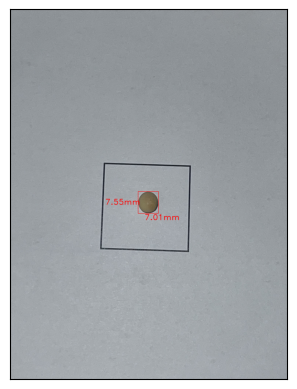

  2%|▏         | 1/42 [00:00<00:31,  1.29it/s]

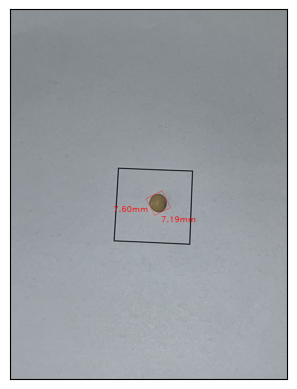

  5%|▍         | 2/42 [00:01<00:31,  1.26it/s]

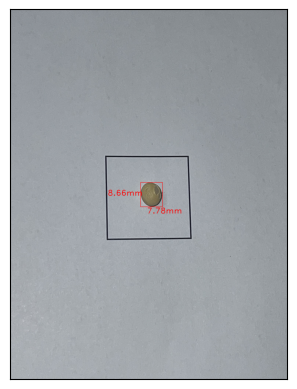

  7%|▋         | 3/42 [00:02<00:26,  1.49it/s]

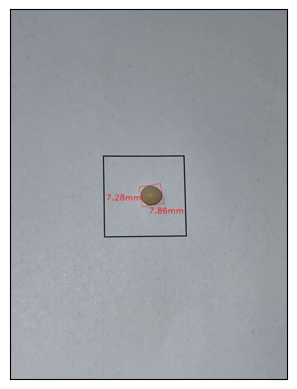

 10%|▉         | 4/42 [00:02<00:23,  1.65it/s]

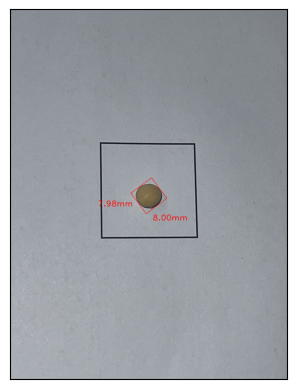

 12%|█▏        | 5/42 [00:03<00:21,  1.74it/s]

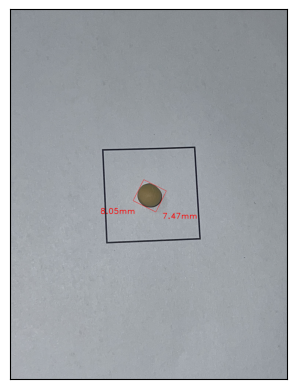

 14%|█▍        | 6/42 [00:04<00:24,  1.48it/s]

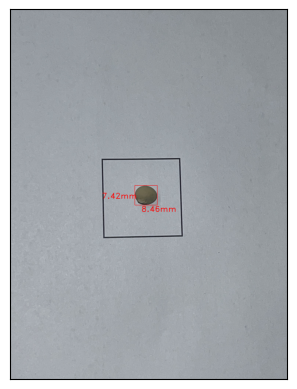

 17%|█▋        | 7/42 [00:04<00:21,  1.60it/s]

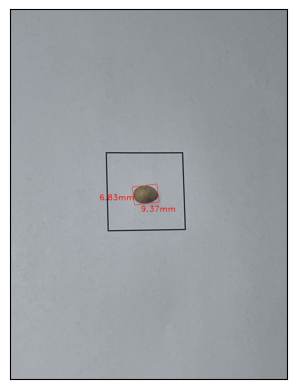

 19%|█▉        | 8/42 [00:05<00:20,  1.64it/s]

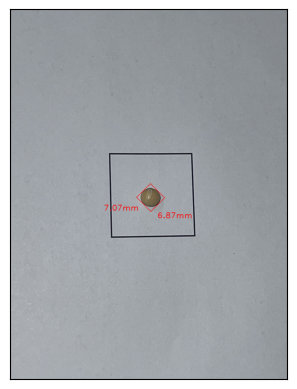

 21%|██▏       | 9/42 [00:05<00:19,  1.67it/s]

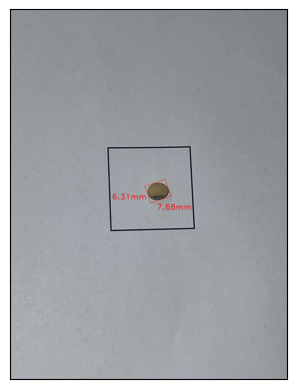

 24%|██▍       | 10/42 [00:06<00:18,  1.72it/s]

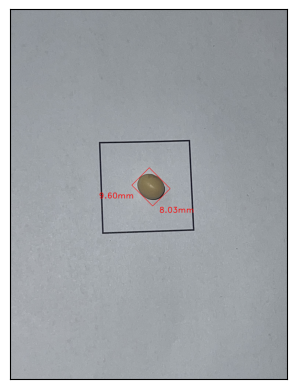

 26%|██▌       | 11/42 [00:06<00:18,  1.68it/s]

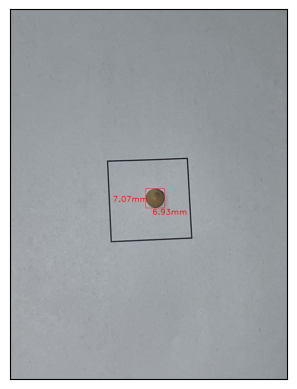

 29%|██▊       | 12/42 [00:07<00:18,  1.60it/s]

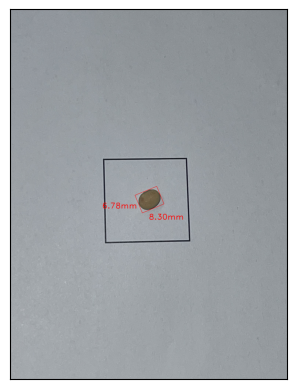

 31%|███       | 13/42 [00:08<00:20,  1.39it/s]

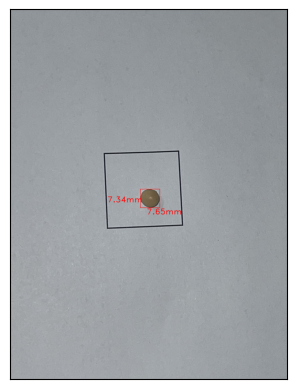

 33%|███▎      | 14/42 [00:09<00:19,  1.42it/s]

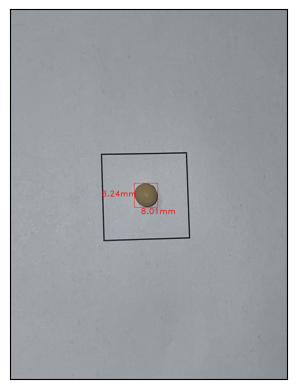

 36%|███▌      | 15/42 [00:09<00:17,  1.54it/s]

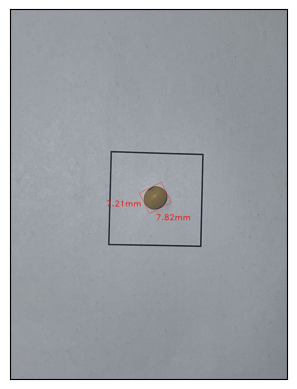

 38%|███▊      | 16/42 [00:10<00:15,  1.63it/s]

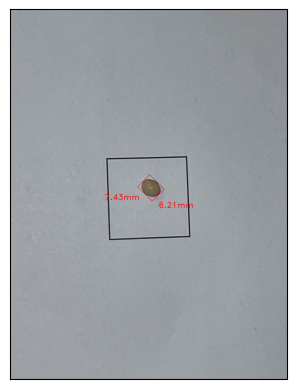

 40%|████      | 17/42 [00:10<00:14,  1.68it/s]

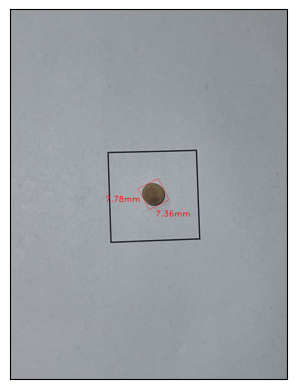

 43%|████▎     | 18/42 [00:11<00:15,  1.59it/s]

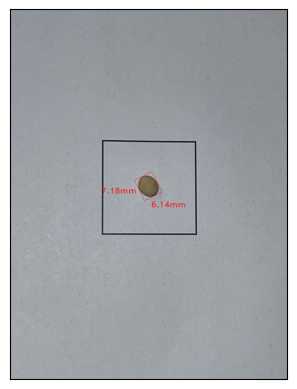

 45%|████▌     | 19/42 [00:12<00:14,  1.61it/s]

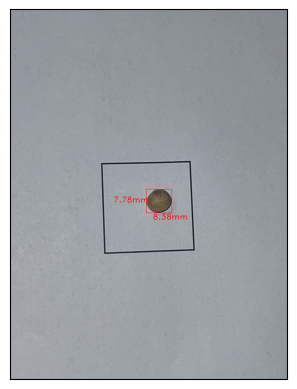

 48%|████▊     | 20/42 [00:12<00:13,  1.58it/s]

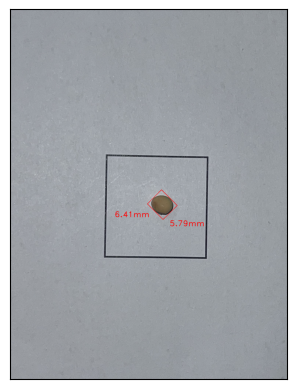

 50%|█████     | 21/42 [00:13<00:13,  1.55it/s]

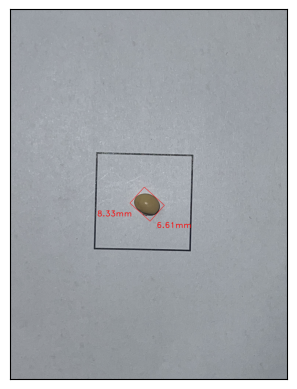

 52%|█████▏    | 22/42 [00:13<00:12,  1.61it/s]

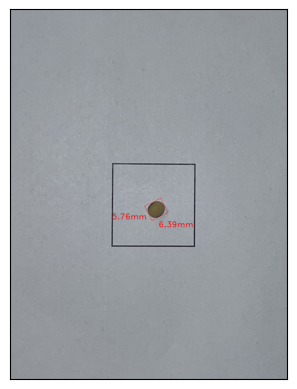

 55%|█████▍    | 23/42 [00:14<00:11,  1.64it/s]

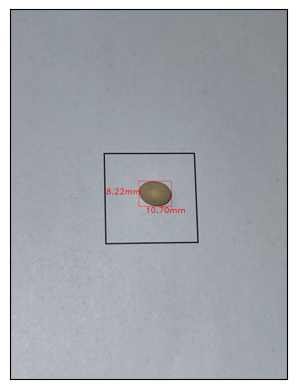

 57%|█████▋    | 24/42 [00:15<00:10,  1.65it/s]

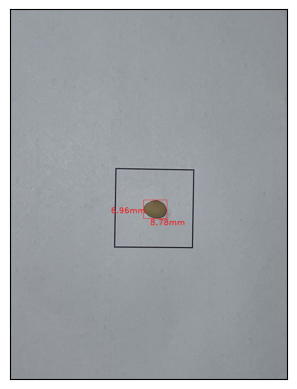

 60%|█████▉    | 25/42 [00:15<00:10,  1.70it/s]

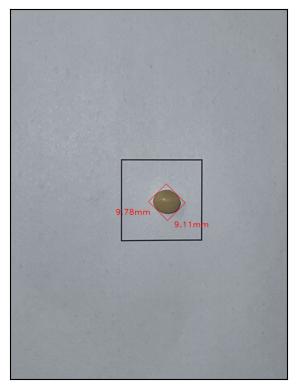

 62%|██████▏   | 26/42 [00:16<00:09,  1.77it/s]

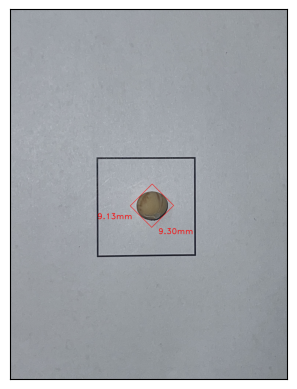

 64%|██████▍   | 27/42 [00:16<00:08,  1.75it/s]

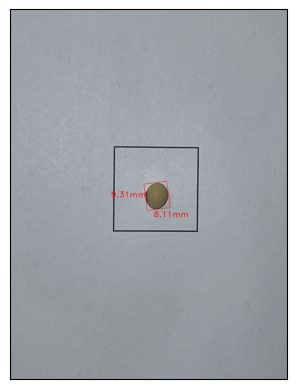

 67%|██████▋   | 28/42 [00:17<00:07,  1.80it/s]

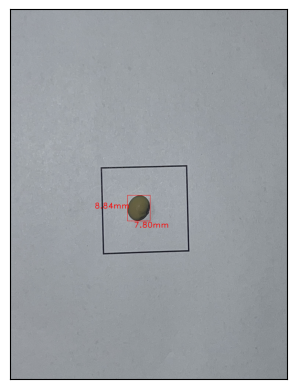

 69%|██████▉   | 29/42 [00:17<00:07,  1.84it/s]

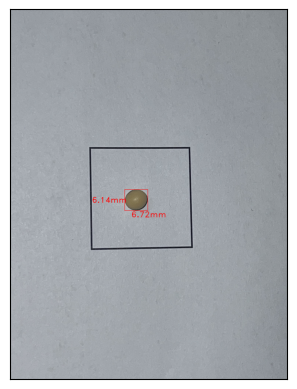

 71%|███████▏  | 30/42 [00:18<00:06,  1.80it/s]

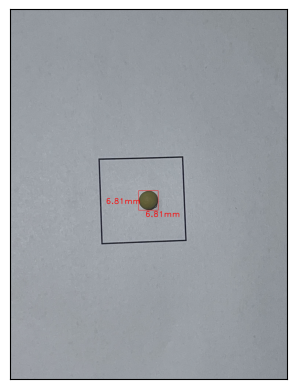

 74%|███████▍  | 31/42 [00:18<00:05,  1.85it/s]

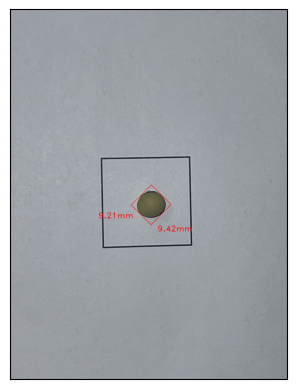

 76%|███████▌  | 32/42 [00:19<00:05,  1.88it/s]

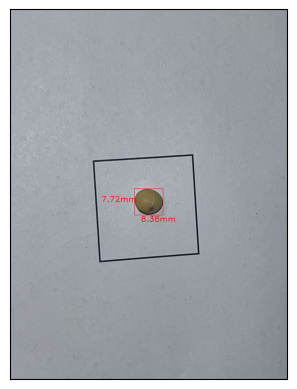

 79%|███████▊  | 33/42 [00:20<00:04,  1.83it/s]

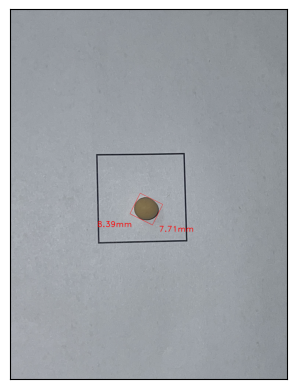

 81%|████████  | 34/42 [00:20<00:04,  1.87it/s]

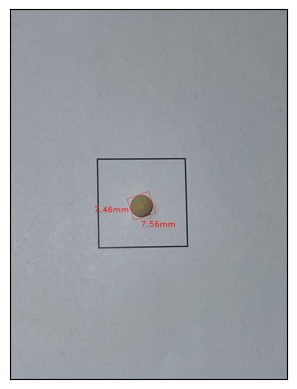

 83%|████████▎ | 35/42 [00:21<00:03,  1.88it/s]

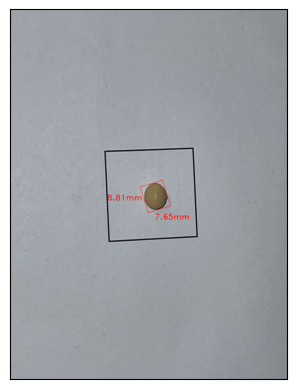

 86%|████████▌ | 36/42 [00:21<00:03,  1.83it/s]

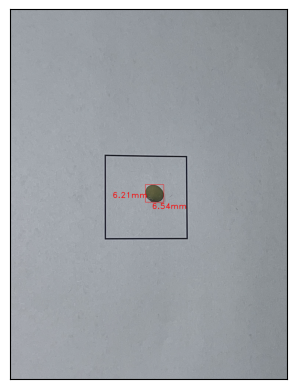

 88%|████████▊ | 37/42 [00:22<00:02,  1.87it/s]

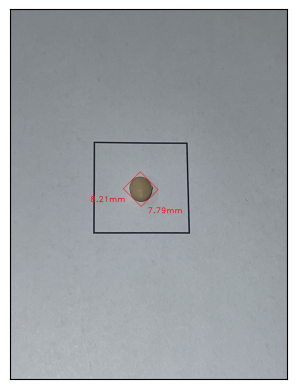

 90%|█████████ | 38/42 [00:22<00:02,  1.90it/s]

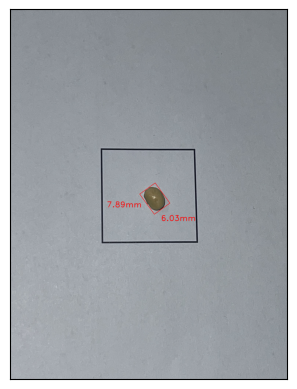

 93%|█████████▎| 39/42 [00:23<00:01,  1.84it/s]

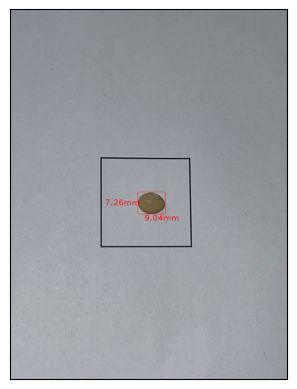

 95%|█████████▌| 40/42 [00:23<00:01,  1.85it/s]

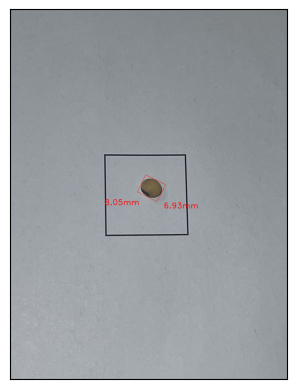

 98%|█████████▊| 41/42 [00:24<00:00,  1.82it/s]

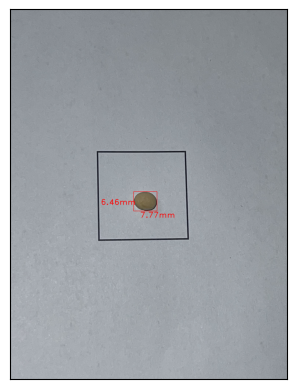

100%|██████████| 42/42 [00:24<00:00,  1.69it/s]

42 0


In [90]:
correct_cnt = 0
fail_cnt = 0
for file_name in tqdm(file_lists):
    try :
        cal_image= measure_size(path+f'Images/{file_name}', paper_eps_param = 0.08) # 작을 수록 많은 값을 코너를 탐지
        show_image(cal_image)
        correct_cnt += 1
    except:
        fail_cnt += 1
print(correct_cnt, fail_cnt)

In [ ]:
# [[[Next, Previous, First_Child, Parent]]] # -1이면 없는 것